In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
# import seaborn as sns
# import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [2]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [4]:
dxx=0.5

In [5]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [6]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'*DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'*DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

In [7]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

# Figure 2 - Methods - Coupling Schematic

In [8]:
%%time
# chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
# tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[0,1:-1,1:-1].compute()

tt=vart.temp.groupby("time_counter.dayofyear").mean()
# tt=tt.chunk(chunks=chunks_new);
tt=tt[:,100:-100,100:-200].compute();
tt=tt[0,1:-1,1:-1]

hf=varf.shflx.groupby("time_counter.dayofyear").mean()
# hf=hf.chunk(chunks=chunks_new);
hf=hf[:,100:-100,100:-200].compute();
hf=hf[:-1,1:-1,1:-1]

ht=vart.shflx.groupby("time_counter.dayofyear").mean()
# ht=ht.chunk(chunks=chunks_new);
ht=ht[:,100:-100,100:-200].compute();
ht=ht[0,1:-1,1:-1]

CPU times: user 1min 10s, sys: 18.4 s, total: 1min 28s
Wall time: 9.37 s


In [10]:
sh_f=regrid(varfw.HFX,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][0][1:-1,1:-1]
sh_t=regrid(vartw.HFX,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][0][1:-1,1:-1]

tw_f=regrid(varfw.SST,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][0][1:-1,1:-1]
tw_t=regrid(vartw.SST,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][0][1:-1,1:-1]

taw_f=regrid(varfw.T2,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][0][1:-1,1:-1]
taw_t=regrid(vartw.T2,
                lons=varf.nav_lon_rho.data[100:-100,100:-200],
                lats=varf.nav_lat_rho.data[100:-100,100:-200],
                which='grid')[0][0][1:-1,1:-1]



Create weight file: bilinear_390x300_1320x700.nc
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1320x700.nc 
 You can set reuse_weights=True to save computing time.


In [72]:
ax.spines.values().set_edgecolor('white')

AttributeError: 'ValuesView' object has no attribute 'set_edgecolor'

In [70]:
a=ax.spines.values()

AttributeError: 'ValuesView' object has no attribute 'set_edgecolor'

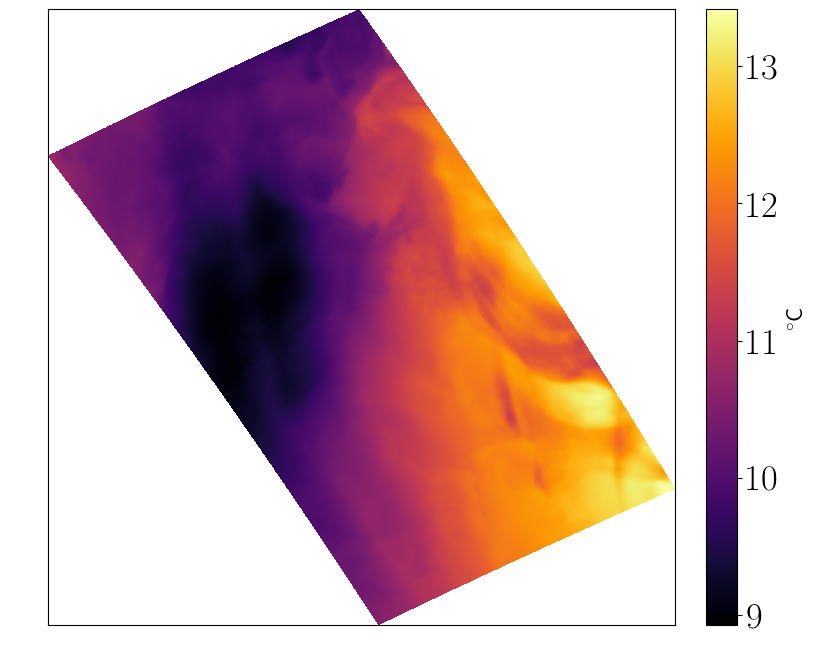

In [68]:
fig=plt.figure(figsize=(10,8))

# plt.subplot(4,2,1)
imm=(taw_f-273.15).plot(x='lon',y='lat',cmap='inferno',add_colorbar=False)
cb = plt.colorbar(imm,pad=0.04)
cb.set_label(label=r'$^{\circ}$C', fontsize=17)
cb.ax.tick_params(labelsize='large')

plt.xlabel('')
plt.ylabel('')
# plt.xticks(None,color='white')
# plt.yticks(None,color='white')
# ax = plt.axes()
# ax.spines['bottom'].set_color('white')
plt.title(r'',fontsize=20)


ax = plt.gca()  # gca stands for 'get current axis'
ax.tick_params(color='white', labelcolor='white')
ax.spines.values().set_edgecolor('white')




# for ax in axes:
#     for spine in ax.spines.values():
#         spine.set_edgecolor('green')
# ax = plt.gca()  # gca stands for 'get current axis'
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')

# plt.setp(ax.spines.values(), color='white')
# plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='white')



# ax.xaxis.set_ticks_position('bottom')
# ax.spines['bottom'].set_position(('data',0))
# ax.yaxis.set_ticks_position('left')
# ax.spines['left'].set_position(('data',0))


plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/T_Air_FULL.png',dpi=300)





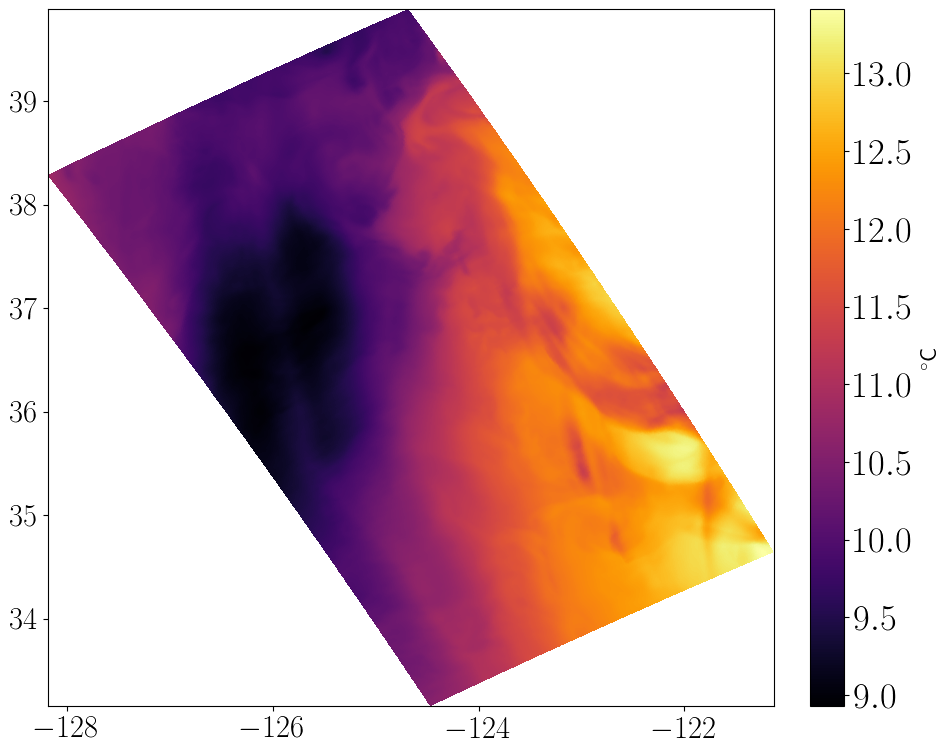

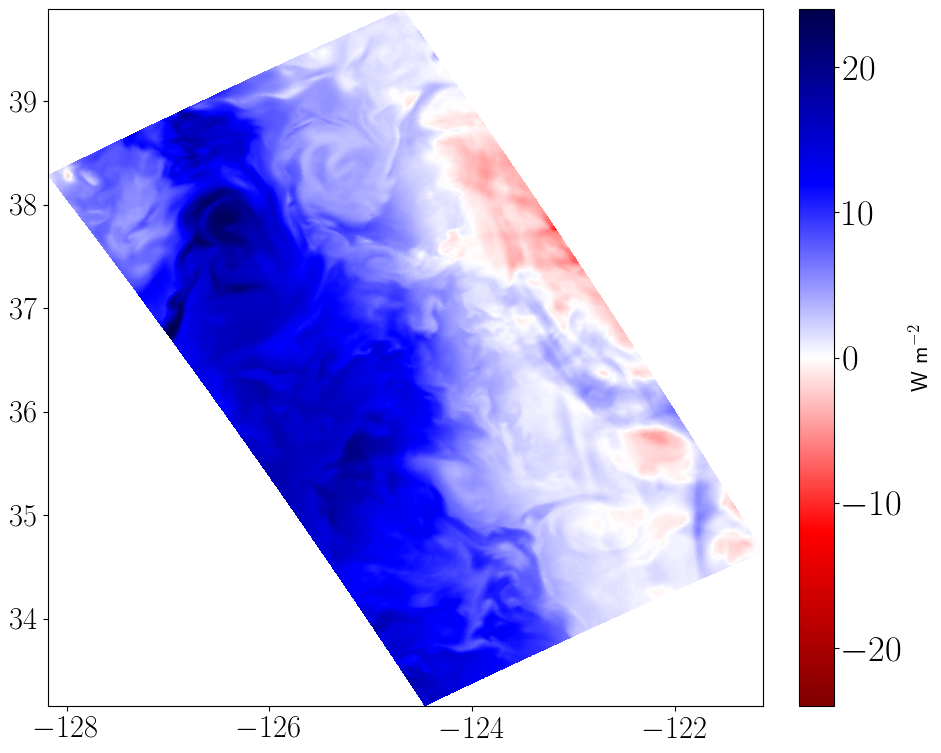

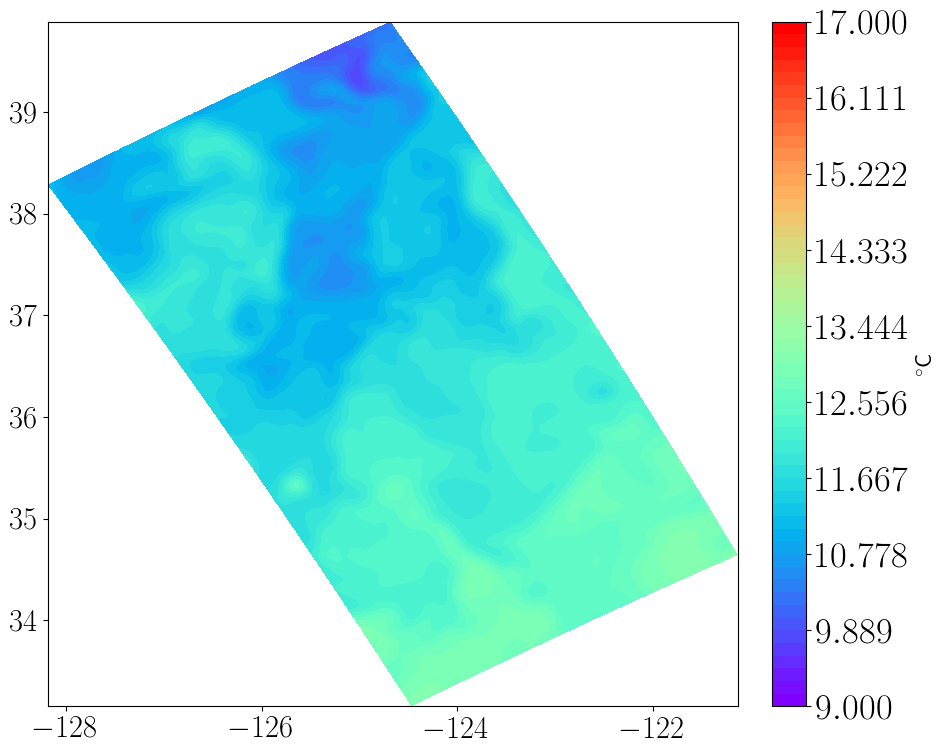

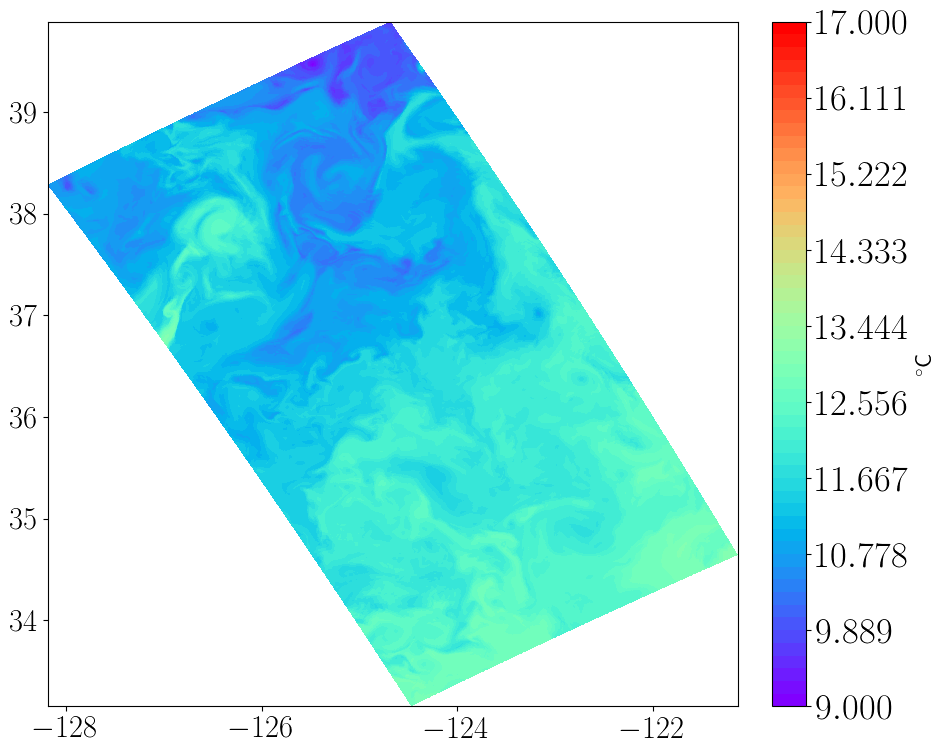

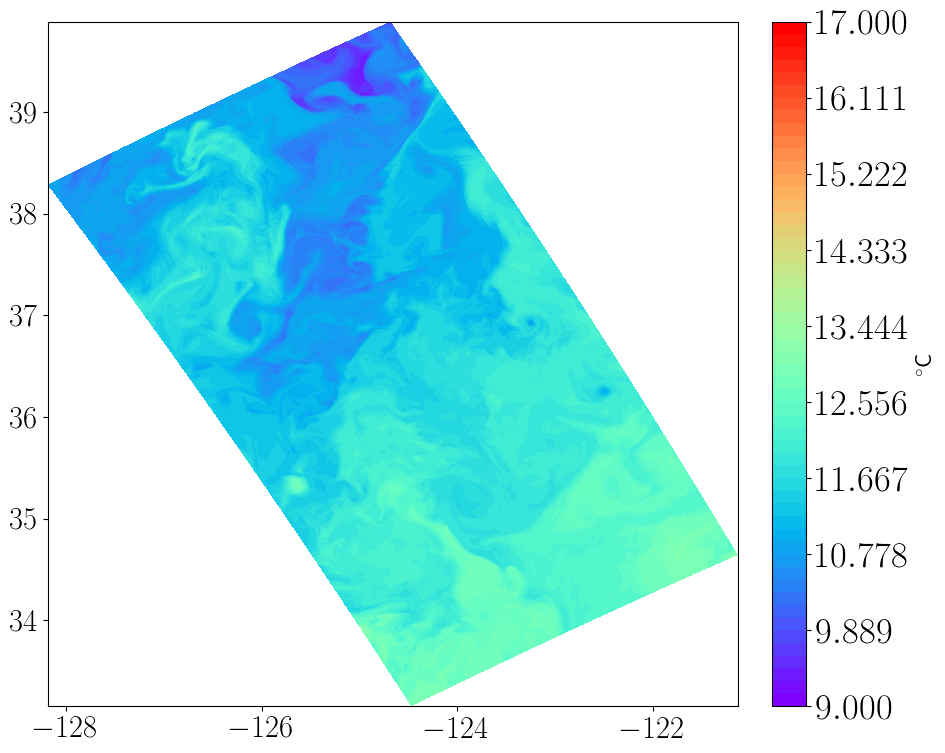

In [57]:

plt.figure(figsize=(10,8))

# plt.subplot(4,2,1)
imm=(taw_f-273.15).plot(x='lon',y='lat',cmap='inferno',add_colorbar=False)
cb = plt.colorbar(imm,pad=0.04)
cb.set_label(label=r'$^{\circ}$C', fontsize=17)
cb.ax.tick_params(labelsize='large')

plt.xlabel('')
plt.ylabel('')
plt.title(r'',fontsize=20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/T_Air_FULL.png',dpi=300)



# plt.subplot(4,2,2)
# im=(taw_t-273.15).plot(x='lon',y='lat',cmap='inferno',add_colorbar=False)
# cb = plt.colorbar(im,pad=0.04)
# cb.set_label(label=r'$^{\circ}$C', fontsize=17)
# cb.ax.tick_params(labelsize='large')

# plt.xlabel('')
# plt.ylabel('')
# plt.title(r'$T_{air}$',fontsize=20)

plt.figure(figsize=(10,8))


# plt.subplot(4,2,3)
im0=(sh_f).plot(x='lon',y='lat',cmap='seismic_r',add_colorbar=False)
cb = plt.colorbar(im0,pad=0.04)
cb.set_label(label=r'W m$^{-2}$', fontsize=17)
cb.ax.tick_params(labelsize='large')
plt.xlabel('')
plt.ylabel('')
plt.title(r'',fontsize=20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/Q_FULL.png',dpi=300)





# plt.subplot(4,2,4)
# im1=(sh_t).plot(x='lon',y='lat',cmap='seismic_r',add_colorbar=False)
# cb = plt.colorbar(im1,pad=0.04)
# cb.set_label(label=r'W m$^{-2}$', fontsize=17)
# cb.ax.tick_params(labelsize='large')
# plt.xlabel('')
# plt.ylabel('')
# plt.title(r'$Q_{s}$',fontsize=20)



# plt.subplot(4,2,5)
# im2=(tw_f-273.15).plot(x='lon',y='lat',levels=np.linspace(9,17,35),cmap='rainbow',add_colorbar=False)
# cb = plt.colorbar(im2,pad=0.04)
# cb.set_label(label=r'$^{\circ}$C', fontsize=17)
# cb.ax.tick_params(labelsize='large')
# plt.xlabel('')
# plt.ylabel('')
# plt.title(r'$SST$ (FULL)',fontsize=20)

plt.figure(figsize=(10,8))
# plt.subplot(4,2,6)
im3=(tw_t-273.15).plot(x='lon',y='lat',levels=np.linspace(9,17,55),cmap='rainbow',add_colorbar=False)
cb = plt.colorbar(im3,pad=0.04)
cb.set_label(label=r'$^{\circ}$C', fontsize=17)
cb.ax.tick_params(labelsize='large')
plt.xlabel('')
plt.ylabel('')
plt.title(r'',fontsize=20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/SST_WRF_SMTH.png',dpi=300)




plt.figure(figsize=(10,8))


# plt.subplot(4,2,7)
im4=tf.plot(x='nav_lon_rho',y='nav_lat_rho',levels=np.linspace(9,17,55),cmap='rainbow',add_colorbar=False)
cb = plt.colorbar(im4,pad=0.04)
cb.set_label(label=r'$^{\circ}$C', fontsize=17)
cb.ax.tick_params(labelsize='large')
plt.xlabel('')
plt.ylabel('')
plt.title(r'',fontsize=20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/SST_FULL.png',dpi=300)





# plt.subplot(4,2,8)
plt.figure(figsize=(10,8))

im5=tt.plot(x='nav_lon_rho',y='nav_lat_rho',levels=np.linspace(9,17,55),cmap='rainbow',add_colorbar=False)
cb = plt.colorbar(im5,pad=0.04)
cb.set_label(label=r'$^{\circ}$C', fontsize=17)
cb.ax.tick_params(labelsize='large')
plt.xlabel('')
plt.ylabel('')
plt.title(r'',fontsize=20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/SST_SMTH.png',dpi=300)


# Figure 1 - Vorticity values and histograms

In [17]:
# def fig1(sizeh,sizev,lnmn,lnmx,ltmn,ltmx,grid_a=0.01):


#     fig = plt.figure(figsize=(sizeh,sizev))
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#     ax.set_extent([lnmn, lnmx, ltmn, ltmx], crs=ccrs.PlateCarree())
#     ax.add_feature(cfeature.LAND.with_scale('10m'),edgecolor='none')
#     ax.add_feature(cfeature.LAKES.with_scale('10m'))


#     # ax.add_feature(cfeature.OCEAN)
#     ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
#     ax.add_feature(cfeature.STATES.with_scale('10m'))


#     ax = plt.axes(projection=ccrs.PlateCarree())
#     gl = ax.gridlines(draw_labels=True,alpha=grid_a)
#     gl.ylabels_right = False
#     gl.xlabels_top = False

In [18]:
chunks_new={'dayofyear':40}

%time
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
ut=ut.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
vt=vt.compute();



CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 15.3 µs


In [19]:
dx=500

In [20]:
vfx=(0.5*(vf[:,1:,:]+vf[:,:-1,:]))[:,:,1:-1]
ufx=(0.5*(uf[:,:,1:]+uf[:,:,:-1]))[:,1:-1,:]

In [21]:
lonx,latx=varf.temp.nav_lon_rho[1:-1,1:-1],varf.temp.nav_lat_rho[1:-1,1:-1]

In [25]:
import seawater as sw
rossby=sw.f(latx.data)

In [28]:
rossby

array([[7.8460442e-05, 7.8465200e-05, 7.8469900e-05, ..., 8.2909595e-05,
        8.2913801e-05, 8.2917999e-05],
       [7.8468853e-05, 7.8473597e-05, 7.8478297e-05, ..., 8.2918064e-05,
        8.2922263e-05, 8.2926461e-05],
       [7.8477242e-05, 7.8481993e-05, 7.8486701e-05, ..., 8.2926505e-05,
        8.2930703e-05, 8.2934901e-05],
       ...,
       [9.0629161e-05, 9.0633977e-05, 9.0638758e-05, ..., 9.5118034e-05,
        9.5122254e-05, 9.5126474e-05],
       [9.0636808e-05, 9.0641603e-05, 9.0646405e-05, ..., 9.5125666e-05,
        9.5129908e-05, 9.5134121e-05],
       [9.0644455e-05, 9.0649242e-05, 9.0654030e-05, ..., 9.5133306e-05,
        9.5137519e-05, 9.5141739e-05]], dtype=float32)

In [30]:
day=150

In [31]:
zeta_f=np.gradient(vfx[day],axis=1)/dx - np.gradient(ufx[day],axis=0)/dx
div_f=np.gradient(ufx[day],axis=1)/dx + np.gradient(vfx[day],axis=0)/dx


In [32]:
strain_f= np.sqrt(
    (np.gradient(ufx[day],axis=1)/dx - np.gradient(vfx[day],axis=0)/dx)**2 + 
    (np.gradient(vfx[day],axis=1)/dx + np.gradient(ufx[day],axis=0)/dx)**2)

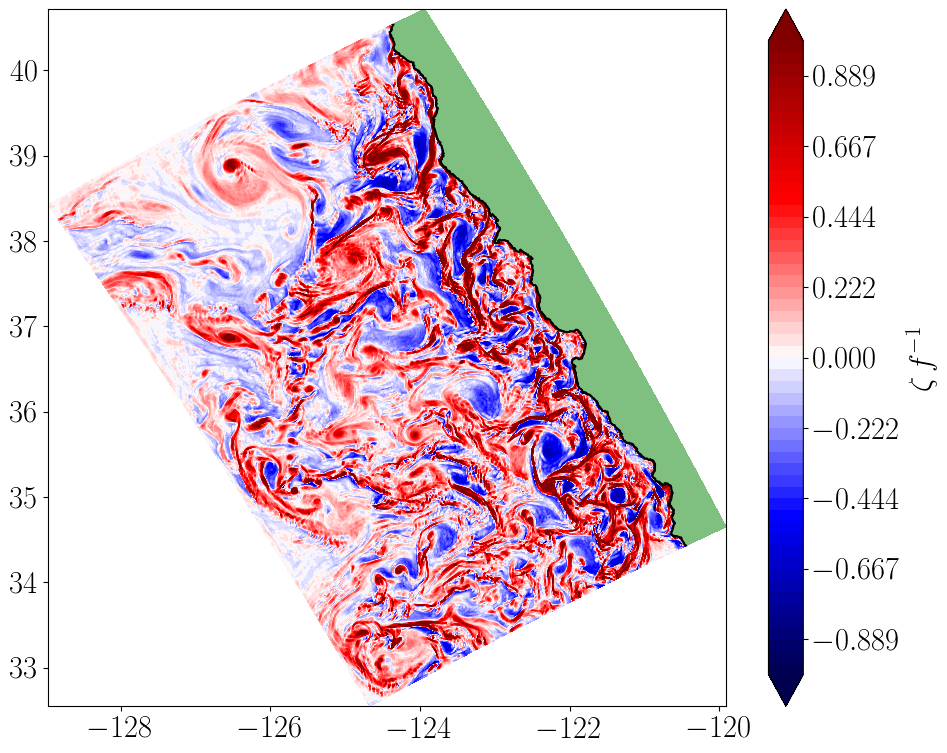

In [36]:
# dec=50
# dd=200
# lnmn=-129;lnmx=-120;ltmn=32;ltmx=41


fig = plt.figure(figsize=(10,8))

plt.contourf(lonx,latx,np.isnan(zeta_f).reshape(zeta_f.shape),levels=np.linspace(0,1),
                extend='both',colors='green',alpha=0.5)
plt.contour(lonx,latx,np.isnan(zeta_f).reshape(zeta_f.shape),levels=np.linspace(1,1.5),colors='k')
cb=plt.contourf(lonx,latx,zeta_f/rossby,levels=np.linspace(-1,1,55),extend='both',cmap='seismic')



cb1=plt.colorbar(cb)
cb1.set_label(r'$\zeta\,f^{-1}$',fontweight='bold') 
# cb1.set_ticks()
# cb1.set_ticks(np.arange(0,1,0.1))
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/simulation_Rossby_example_b.png')



(array([  393.59860229,     0.        ,     0.        ,   393.59910445,
            0.        ,   393.59910445,     0.        ,   393.59860229,
         1180.79731336,  1967.99552226,  1574.39440915,  4723.18925343,
         5116.78835788,  7084.77936066,  9052.77362751,  9446.37850685,
         7084.77936066,  3542.38968033, 13382.36955137, 14956.75642806,
        25583.93362922, 26764.73056595, 45657.4742723 , 46838.27475556,
        36604.7021199 , 23615.93496843, 16924.75339404, 14563.16221971,
         9839.97447278, 11414.37038842,  2361.59312022,  1574.39641781,
         1574.39541348,  1180.79656011,     0.        ,  1180.79580686,
            0.        ,   393.59910445,   787.1982089 ,     0.        ,
          393.59910445,   393.59910445,     0.        ,     0.        ,
          393.59910445,     0.        ,   787.19720458,   787.19720458,
            0.        ,   393.59860229]),
 array([-6.8674373e-05, -6.5822904e-05, -6.2971441e-05, -6.0119972e-05,
        -5.7268506e-05

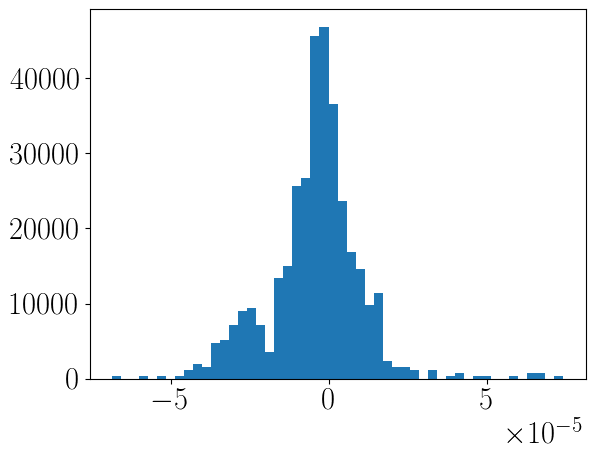

In [53]:
plt.hist(zeta_f[0][~np.isnan(zeta_f[0])],bins=50,density=True)